# Racing Analysis

In [46]:
from capo.load_datasets import get_tasks
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
dataset = "sst-5"
optimizer = "CAPO"  # "EvoPromptGA" # CAPO
model = "llama"
seed = 42

In [48]:
task, _, _ = get_tasks(
    dataset_name=dataset,
    optimizer_name=optimizer,
    seed=seed,
    block_size=30,
)

init_prompts = task.initial_prompts;

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
C:\Users\schla\git\capo\capo\load_datasets.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "input"] = df[config.input]
C:\Users\schla\git\capo\capo\load_datasets.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "target"] = config.target(df)
C:\Users\schla\git\capo\capo\load_datasets.py:72: SettingWithCopyWarning: 
A value is trying to be set on a 

## Initial Prompts Analysis

In [49]:
path = glob(f"../results/agnews/*/CAPO/*/*/*/step_results_eval.csv")[0]
df = pd.read_csv(path)

In [50]:
df["contains_init"] = df["prompt"].apply(lambda x: any([prompt in x for prompt in init_prompts]))

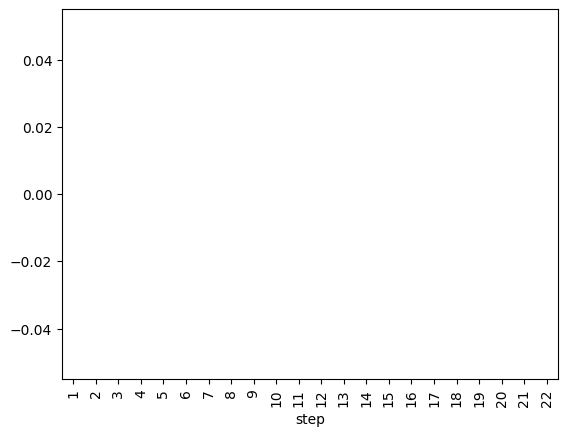

In [51]:
df.groupby("step").mean(numeric_only=True)["contains_init"].plot(kind="bar");

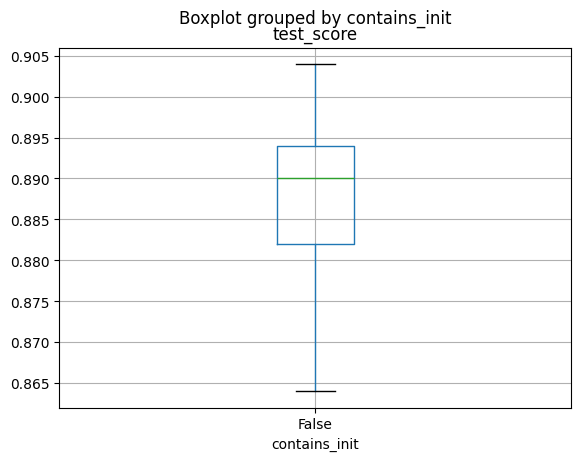

In [52]:
# boxplot
df.groupby("prompt").first().boxplot(column="test_score", by="contains_init");

In [53]:
# get the init prompt that dominates
df[df["contains_init"]].groupby("prompt", as_index=False).mean(numeric_only=True)[
    ["prompt", "test_score"]
].sort_values("test_score", ascending=False)

,prompt,test_score


## Prompt Survival Analysis

In [54]:
import plotly.express as px

In [ ]:
path = r"../results/racing_experiment_CAPO_AVG\203180173869d5b1259e37bbfca1e5b8f33fe67dd894a57c8596295014c7459a\step_results.csv"
df = pd.read_csv(path)

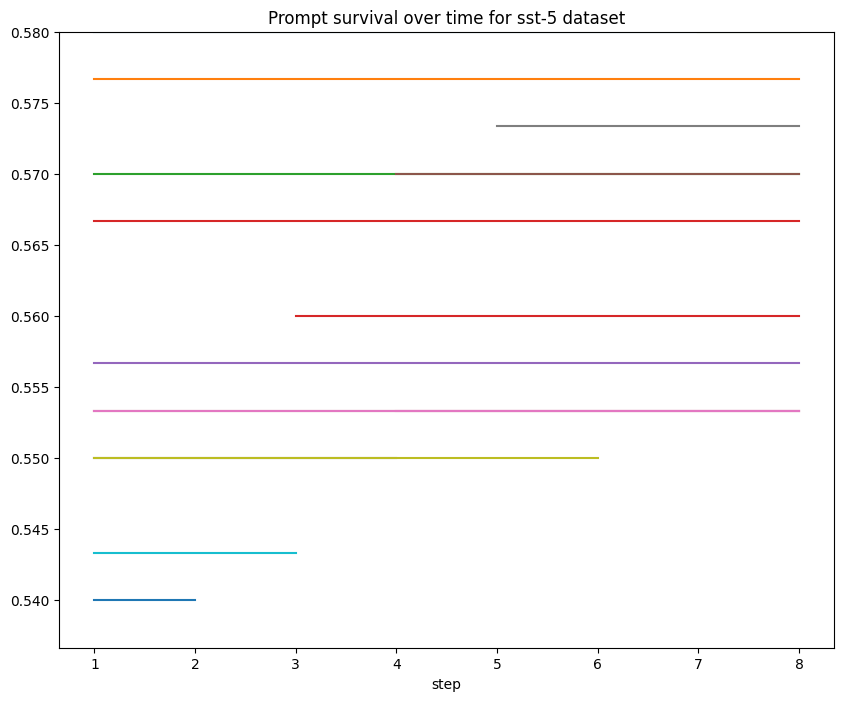

In [77]:
fig, ax = plt.subplots(figsize=(10, 8))
for prompt in df["prompt"].unique():
    df[df["prompt"] == prompt].plot(x="step", y="score", ax=ax)  # <-- changed to test_score
ax.get_legend().remove()
ax.set_ylim(min(df["score"]), max(df["score"]))  # <-- changed to test_score
ax.set_title(f"Prompt survival over time for {dataset} dataset")
plt.show()

## Block Score Analysis

In [56]:
df["prompt_short"] = df["prompt"].apply(lambda x: " ".join(x.split()[:20]))

In [80]:
path = r"../results/racing_experiment_CAPO_AVG\203180173869d5b1259e37bbfca1e5b8f33fe67dd894a57c8596295014c7459a\prompt_scores.csv"
prompt_scores_df = pd.read_csv(path)
prompt_scores_df.rename(columns={"Unnamed: 0": "prompt"}, inplace=True)

ParserError: Error tokenizing data. C error: Expected 136 fields in line 136, saw 166


In [58]:
# count how many columns have no missing values and add it as a column
prompt_scores_df["evaluated_blocks"] = 10 - prompt_scores_df.isnull().sum(axis=1)

In [59]:
blocks_df = prompt_scores_df[["prompt", "step", "evaluated_blocks"]]

In [60]:
prompt_scores_df

,prompt,0,1,2,3,4,5,6,7,8,9,step,evaluated_blocks
0,Analyze the given movie review to determine it...,0.666667,0.566667,0.633333,0.333333,0.400000,0.400000,0.700000,0.533333,0.700000,0.466667,0,10
1,Analyze the sentiment expressed in this film c...,0.733333,0.600000,0.633333,0.433333,0.533333,0.566667,0.533333,0.633333,0.633333,0.466667,0,10
2,"Assess the sentiment of a movie review, catego...",0.666667,0.633333,0.666667,0.433333,0.433333,0.400000,0.600000,0.533333,0.600000,0.400000,0,10
3,Assess the tone of the provided film review an...,0.633333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
4,Classify the sentiment in this cinema critique...,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3366,"To determine the sentiment of a movie review, ...",0.733333,0.466667,0.666667,0.400000,0.566667,0.533333,0.633333,0.566667,0.566667,0.433333,37,10
3367,"To evaluate the sentiment of a movie review, d...",0.633333,0.533333,0.700000,0.433333,0.266667,NaN,NaN,NaN,NaN,NaN,37,5
3368,"To evaluate the sentiment of a movie review, d...",0.666667,0.600000,0.666667,0.400000,0.466667,0.433333,NaN,NaN,NaN,NaN,37,6
3369,"To evaluate the sentiment of a movie review, d...",0.766667,0.600000,0.666667,0.400000,0.533333,0.533333,0.600000,0.566667,0.600000,0.433333,37,10


In [61]:
df_with_blocks = df.merge(blocks_df, on=["prompt", "step"], how="left")
df_with_blocks

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,test_score,contains_init,prompt_short,evaluated_blocks
0,1,2025-03-16 05:32:51.754825,1130.566318,0.882261,Read the following news text and determine whi...,1451,620,1139225,72545,0.892,False,Read the following news text and determine whi...,NaN
1,1,2025-03-16 05:32:51.754825,1130.566318,0.878243,You are a news categorization system. Read the...,1451,620,1139225,72545,0.894,False,You are a news categorization system. Read the...,NaN
2,1,2025-03-16 05:32:51.754825,1130.566318,0.876868,Your mission is to sort news stories into dist...,1451,620,1139225,72545,0.898,False,Your mission is to sort news stories into dist...,NaN
3,1,2025-03-16 05:32:51.754825,1130.566318,0.874520,Please review this news article carefully. Bas...,1451,620,1139225,72545,0.900,False,Please review this news article carefully. Bas...,NaN
4,1,2025-03-16 05:32:51.754825,1130.566318,0.868722,Analyze this news article and identify whether...,1451,620,1139225,72545,0.898,False,Analyze this news article and identify whether...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,22,2025-03-16 07:11:23.188179,334.533651,0.864751,Examine the provided news article and categori...,2002,1038,301339,26105,0.890,False,Examine the provided news article and categori...,NaN
260,22,2025-03-16 07:11:23.188179,334.533651,0.864378,Examine the news article's content and determi...,2002,1038,301339,26105,0.904,False,Examine the news article's content and determi...,NaN
261,22,2025-03-16 07:11:23.188179,334.533651,0.859715,Examine the news article thoroughly and determ...,2002,1038,301339,26105,0.902,False,Examine the news article thoroughly and determ...,NaN
262,22,2025-03-16 07:11:23.188179,334.533651,0.859540,You are tasked with categorizing news articles...,2002,1038,301339,26105,0.890,False,You are tasked with categorizing news articles...,NaN


In [62]:
# do the same with plotly
fig = px.line(
    df_with_blocks,
    x="step",
    y="test_score",  # <--
    color="prompt",
    custom_data=[df_with_blocks["prompt_short"], df_with_blocks["evaluated_blocks"]],
)
fig.update_xaxes(title="step")
fig.update_layout(title=f"Prompt survival over time for {dataset} dataset")

# # do not show the legend
fig.update_layout(showlegend=False, height=800)

# # show prompt_short instead of prompt in the hover
fig.update_traces(
    hovertemplate="prompt: %{customdata[0]}<br>score: %{y}<br>test score:%{customdata[2]}<br>evaluated blocks:%{customdata[1]}",
    name="",
)
fig.show()

In [63]:
# analyze what happened between step 18 and 19
step_18 = prompt_scores_df[prompt_scores_df["step"] == 18]
step_19 = prompt_scores_df[prompt_scores_df["step"] == 19]

In [64]:
# population in step 18 and 19
pop18 = list(df[df["step"] == 18]["prompt"])
pop19 = list(df[df["step"] == 19]["prompt"])

pops = pop18 + pop19
pops_unique = list(set(pops))

In [65]:
# count how many duplicates are in pop18 and pop19
pop18_count = {p: pops.count(p) for p in pops_unique}
pop19_count = {p: pops.count(p) for p in pops_unique}

pop18_count

{"You are tasked with categorizing news articles into four predefined categories: World, Sports, Business, and Sci/Tech. Your goal is to carefully read each article and identify the category that best aligns with its content. Once you've made your determination, format your response as follows: <final_answer>selected category</final_answer>, ensuring that the article is correctly classified into one of the four available categories: World, Sports, Business, or Sci/Tech.\r\n\r\nInput: Pay dispute ends in South Africa South Africa's wage dispute ends after unions representing public sector workers accept a revised government offer.\r\nOutput: <final_answer>Business</final_answer>\r\n\r\nInput: IBM launches Websphere 6 IBM today announced that Websphere 6, the long awaited-update to its application server software, will be available by the end of the year.\r\nOutput: <final_answer>Sci/Tech</final_answer>\r\n\r\nInput: It #39;s on to LA for the Giants Bee Staff Writer. SAN DIEGO - The San 

In [66]:
# check which prompts are new in step 19
new_prompts = step_19[~step_19["prompt"].isin(step_18["prompt"])]
new_prompts

,prompt,0,1,2,3,4,5,6,7,8,9,step,evaluated_blocks
1001,Assess the emotional undertones and opinion in...,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,1
1005,Assess the sentiment of a given movie review b...,0.666667,0.533333,0.533333,0.500000,0.600000,0.533333,0.466667,0.700000,0.633333,0.433333,19,10
1010,"Assess the sentiment of a given movie review, ...",0.733333,0.566667,0.666667,0.466667,0.566667,0.566667,0.666667,0.566667,0.633333,0.400000,19,10
1054,"Evaluate the sentiment of a movie review, dete...",0.633333,0.533333,0.600000,0.466667,0.500000,0.500000,NaN,NaN,NaN,NaN,19,6
